### Импорты и Настройки

In [13]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from tqdm.auto import tqdm
from glob import glob
from pathlib import Path

# Добавляем корень проекта в путь, чтобы видеть src
sys.path.append(os.path.abspath('..'))

from src.system_metric import MetricLearningSystem # Или TripletSystem
from src.data_loaders.ssl_transforms import create_ssl_transform
from src.utils.serialization import load_pickle

# --- КОНФИГУРАЦИЯ ---

DATA_ROOT = "D:/coding/data/birds_common/data_russian" # Твой путь к данным
CHECKPOINT_PATH = "D:/coding/source/dissertation/bird_training/outputs/2025-12-21/15-48-06/checkpoints/arcface-epoch=13-val_f1=0.7143.ckpt" # УКАЖИ ПУТЬ К ЧЕКПОИНТУ
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {DEVICE}")

Device: cuda


In [14]:
import os
import sys

# Проверяем, где мы находимся. Если в папке notebooks, поднимаемся выше.
if os.getcwd().endswith('notebooks'):
    os.chdir('..')

# Добавляем корень проекта в системный путь, чтобы Python видел папку src
sys.path.append(os.getcwd())

print(f"Current working directory: {os.getcwd()}")
# Должно быть: D:\coding\source\dissertation\bird_training

Current working directory: d:\coding\source\dissertation\bird_training


### Загрузка и подготовка данных (DataFrames)

In [15]:
def fix_path(path, root):
    """Исправляет пути из манифеста под локальную систему"""
    # Если путь в CSV абсолютный линуксовый, обрезаем и клеим к нашему root
    if 'mel' in path:
        rel = path.split('mel')[-1].replace('\\', '/').strip('/')
        # Иногда слеши дублируются
        if rel.startswith('xeno_canto'): rel = f"xeno_canto/{rel[10:]}"
        if rel.startswith('birdclef'): rel = f"birdclef/{rel[8:]}"
        
        full_path = os.path.join(root, 'mel', rel)
    else:
        full_path = path
        
    return os.path.normpath(full_path)

def load_split(split_name):
    """Загружает все CSV из папки сплита"""
    folder = os.path.join(DATA_ROOT, 'splits', split_name)
    files = glob(os.path.join(folder, "*.csv"))
    if not files:
        # Пробуем как файл
        single_file = os.path.join(DATA_ROOT, 'splits', f"{split_name}.csv")
        if os.path.exists(single_file):
            files = [single_file]
    
    dfs = []
    for f in files:
        dfs.append(pd.read_csv(f))
    
    if not dfs: return pd.DataFrame()
    
    df = pd.concat(dfs, ignore_index=True)
    # Чиним пути
    df['local_path'] = df['mel_path'].apply(lambda x: fix_path(str(x), DATA_ROOT))
    # Проверяем существование (быстрая проверка первого файла)
    if len(df) > 0 and not os.path.exists(df.iloc[0]['local_path']):
        print(f"⚠️ ВНИМАНИЕ: Файлы не найдены по пути: {df.iloc[0]['local_path']}")
        print("Проверьте DATA_ROOT")
    
    return df

# Загружаем
df_train = load_split('train')
df_val = load_split('val')
df_unseen = load_split('unseen_test')

print(f"Train samples: {len(df_train)}")
print(f"Val samples:   {len(df_val)}")
print(f"Unseen samples:{len(df_unseen)}")

# Уникальные классы
seen_classes = set(df_train['species'].unique())
unseen_classes = set(df_unseen['species'].unique())
print(f"Seen Classes: {len(seen_classes)}")
print(f"Unseen Classes: {len(unseen_classes)}")
print(f"Overlap (должен быть 0): {len(seen_classes.intersection(unseen_classes))}")

Train samples: 14056
Val samples:   2652
Unseen samples:159
Seen Classes: 30
Unseen Classes: 10
Overlap (должен быть 0): 0


### Анализ распределения классов (EDA)

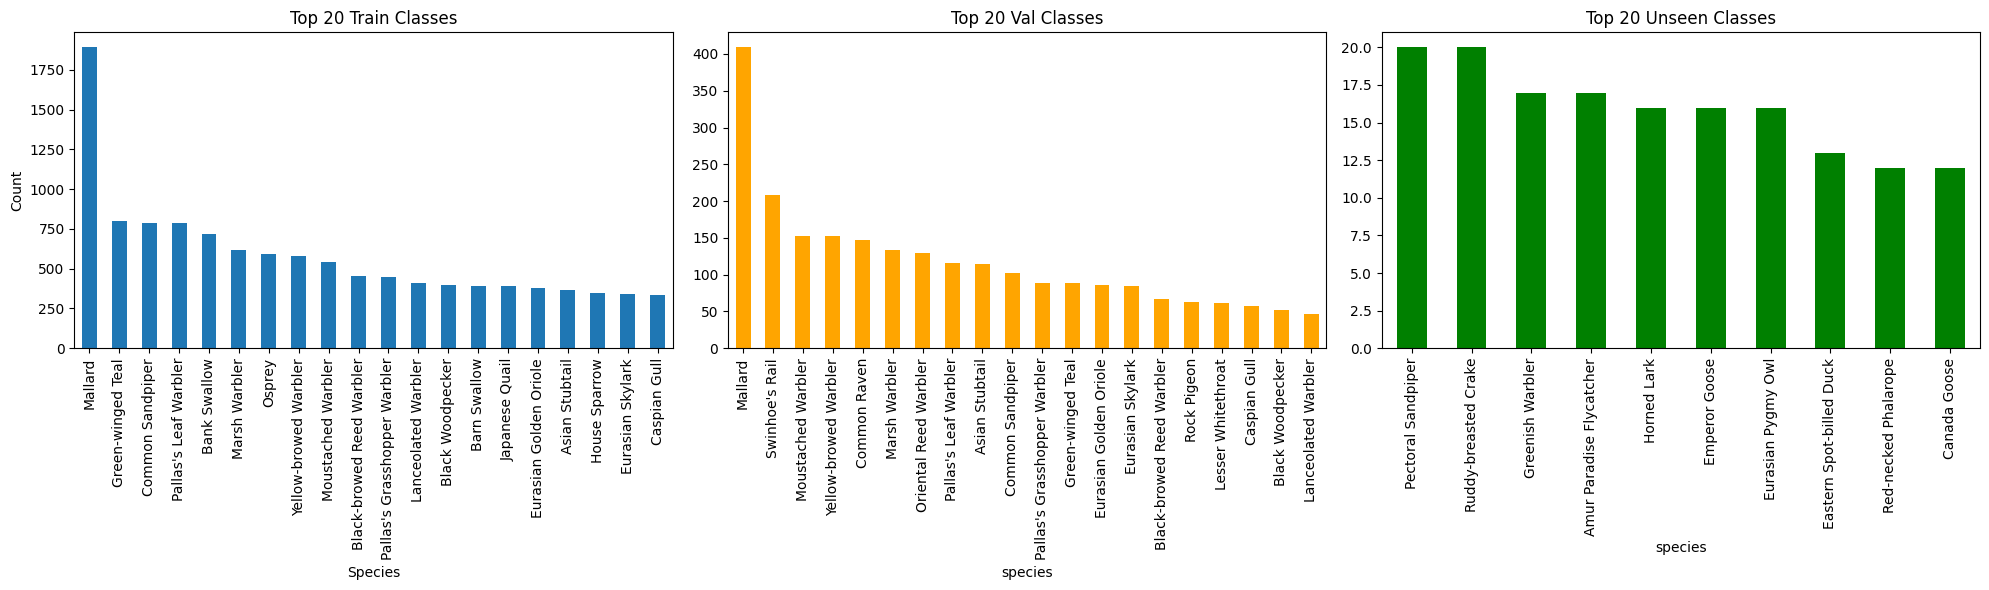

In [6]:
plt.figure(figsize=(20, 6))

# Топ-20 классов в Train
plt.subplot(1, 3, 1)
df_train['species'].value_counts().head(20).plot(kind='bar', title='Top 20 Train Classes')
plt.xlabel('Species')
plt.ylabel('Count')

# Топ-20 классов в Val
plt.subplot(1, 3, 2)
df_val['species'].value_counts().head(20).plot(kind='bar', color='orange', title='Top 20 Val Classes')

# Классы в Unseen (они могут быть редкими)
plt.subplot(1, 3, 3)
df_unseen['species'].value_counts().head(20).plot(kind='bar', color='green', title='Top 20 Unseen Classes')

plt.tight_layout()
plt.show()

### Визуализация Аугментаций

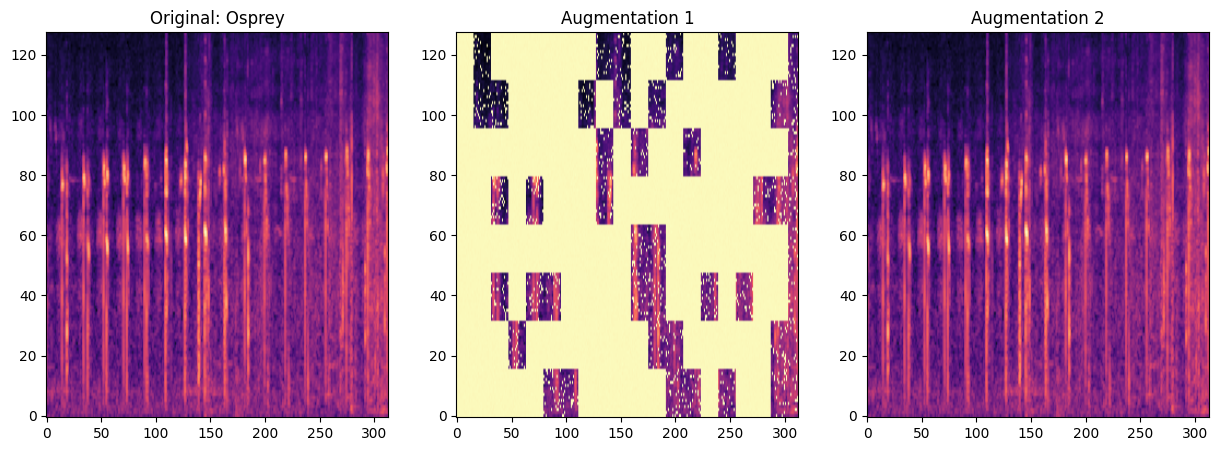

In [9]:
# Создаем аугментатор
augmentor = create_ssl_transform(strength="medium", mode='reconstruction')
# Берем случайный файл
row = df_train.sample(1).iloc[0]
mel = np.load(row['local_path'])
mel_tensor = torch.from_numpy(mel).float()

# Аугментируем
with torch.no_grad():
    # SSLAugmentations возвращает список [x1, x2]
    views = augmentor(mel_tensor)

# Рисуем
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Оригинал
axes[0].imshow(mel, origin='lower', aspect='auto', cmap='magma')
axes[0].set_title(f"Original: {row['species']}")

# View 1
axes[1].imshow(views[0].squeeze().numpy(), origin='lower', aspect='auto', cmap='magma')
axes[1].set_title("Augmentation 1")

# View 2
axes[2].imshow(views[1].squeeze().numpy(), origin='lower', aspect='auto', cmap='magma')
axes[2].set_title("Augmentation 2")

plt.show()

### Загрузка Модели

In [16]:
from typing import Any
import torch
from omegaconf import DictConfig, ListConfig
from omegaconf.base import ContainerMetadata 
# Разрешаем Hydra-конфиги
torch.serialization.add_safe_globals([Any])

# Загружаем модель из чекпоинта
# Важно: убедись, что system_metric.py или system_triplet.py импортирован
try:
    model = MetricLearningSystem.load_from_checkpoint(CHECKPOINT_PATH, map_location=DEVICE,  weights_only=False)
    print("Loaded MetricLearningSystem (ArcFace)")
except:
    # Если это был триплет
    from src.system_triplet import TripletSystem
    model = TripletSystem.load_from_checkpoint(CHECKPOINT_PATH, map_location=DEVICE,  weights_only=False)
    print("Loaded TripletSystem")

model.to(DEVICE)
model.eval()
print("Model ready.")

d:\coding\source\dissertation\bird_training\.venv\lib\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


Loading custom weights from: pretrained/ssl_simCLR_final__efficientnet.pth
Loaded 358 layers from custom checkpoint.
Loaded MetricLearningSystem (ArcFace)
Model ready.


### Функция извлечения эмбеддингов

In [17]:
def extract_embeddings(model, df, batch_size=64):
    embeddings = []
    labels = []
    species_names = []
    
    # Простой цикл по датафрейму (без DataLoader для прозрачности, но можно и с ним)
    # Разбиваем на батчи вручную
    num_samples = len(df)
    
    for i in tqdm(range(0, num_samples, batch_size)):
        batch_df = df.iloc[i : i + batch_size]
        
        # Загрузка
        batch_mels = []
        for _, row in batch_df.iterrows():
            try:
                m = np.load(row['local_path'])
                batch_mels.append(torch.from_numpy(m).float())
            except:
                continue # Skip broken
        
        if not batch_mels: continue
            
        # Паддинг или ресайз если нужно (если батч разного размера - PANNs требует одинакового)
        # Предполагаем, что все 128x313. Если нет - надо ресайзить.
        # Для безопасности сделаем unsqueeze
        batch_tensor = torch.stack(batch_mels)
        if batch_tensor.ndim == 3: batch_tensor = batch_tensor.unsqueeze(1)
        
        batch_tensor = batch_tensor.to(DEVICE)
        
        with torch.no_grad():
            # Получаем эмбеддинги (выход backbone + projection, но БЕЗ головы классификации)
            # В MetricLearningSystem forward возвращает логиты.
            # Нам нужны именно фичи ДО последней головы (или выход projection head).
            
            # Вариант 1: У модели есть метод forward_features (если это PANNs)
            # Вариант 2: Вызываем backbone + projector вручную
            
            # 1. Frontend
            x = model.frontend(batch_tensor)
            # 2. Backbone
            feats = model.backbone(x)
            
            # 3. Если есть projector (для триплета) или просто берем выход бэкбона (для ArcFace)
            # Обычно для ArcFace берут features и нормализуют
            # Для Triplet берут model.head(features)
            
            if hasattr(model, 'head') and 'ProjectionHead' in str(type(model.head)):
                 emb = model.head(feats) # Triplet/SSL проекция
            else:
                 # Для ArcFace Head возвращает логиты, нам они не нужны для UMAP.
                 # Нам нужен вектор перед головой.
                 # Если PANNs - это (B, 2048)
                 # Если EfficientNet - это (B, 1280, F, T) -> надо пульнуть
                 if feats.ndim == 4:
                     feats = torch.nn.functional.adaptive_avg_pool2d(feats, 1).flatten(1)
                 elif feats.ndim == 3:
                     feats = feats.mean(dim=1)
                 
                 emb = feats

            # Нормализация (важно для метрического пространства!)
            emb = torch.nn.functional.normalize(emb, p=2, dim=1)
            
        embeddings.append(emb.cpu().numpy())
        species_names.extend(batch_df['species'].values)
        
    return np.concatenate(embeddings), np.array(species_names)

print("Extracting SEEN (Val) embeddings...")
# Берем не весь Val, если он огромный, а, скажем, 2000 сэмплов для скорости
df_val_subset = df_val #.sample(n=min(2000, len(df_val)), random_state=42)
emb_val, y_val = extract_embeddings(model, df_val_subset)

print("Extracting UNSEEN embeddings...")
emb_unseen, y_unseen = extract_embeddings(model, df_unseen)

print(f"Val shape: {emb_val.shape}")
print(f"Unseen shape: {emb_unseen.shape}")

Extracting SEEN (Val) embeddings...


  0%|          | 0/42 [00:00<?, ?it/s]

Extracting UNSEEN embeddings...


  0%|          | 0/3 [00:00<?, ?it/s]

Val shape: (2652, 1280)
Unseen shape: (159, 1280)


### Визуализация UMAP (Seen vs Unseen)

In [18]:
# Объединяем для фиттинга UMAP
# (UMAP лучше строить на всем вместе, или зафитить на Val и трансформировать Unseen)
all_embs = np.concatenate([emb_val, emb_unseen])
all_labels = np.concatenate([y_val, y_unseen])
is_unseen = np.concatenate([np.zeros(len(y_val)), np.ones(len(y_unseen))]) # 0 = Seen, 1 = Unseen

print("Fitting UMAP... (this may take a while)")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(all_embs)

# Разделяем обратно
umap_val = embedding_2d[:len(emb_val)]
umap_unseen = embedding_2d[len(emb_val):]

Fitting UMAP... (this may take a while)


d:\coding\source\dissertation\bird_training\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


### Графики (Global View)

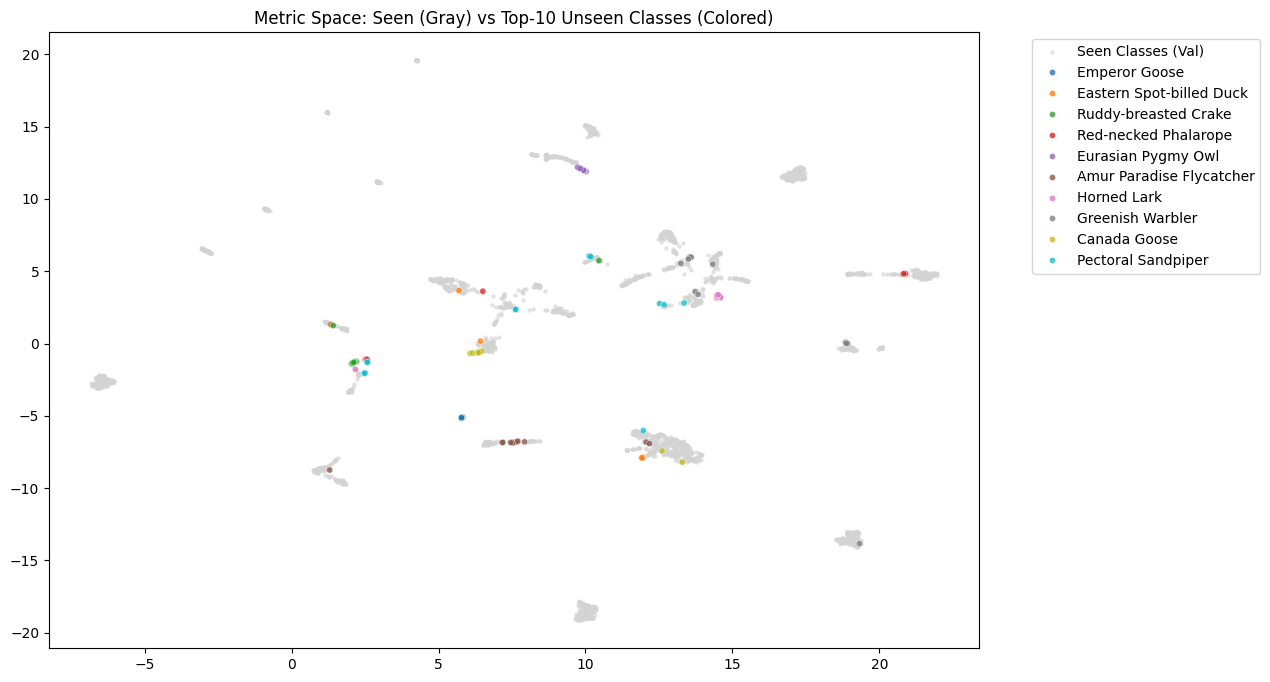

In [19]:
plt.figure(figsize=(12, 8))

# Рисуем Seen (серым, чтобы создать фон)
plt.scatter(umap_val[:, 0], umap_val[:, 1], s=5, c='lightgray', alpha=0.5, label='Seen Classes (Val)')

# Рисуем Unseen (цветным)
# Чтобы не было каши, выберем топ-10 самых частых unseen классов
top_unseen = pd.Series(y_unseen).value_counts().head(10).index
mask = np.isin(y_unseen, top_unseen)

sns.scatterplot(
    x=umap_unseen[mask, 0], 
    y=umap_unseen[mask, 1], 
    hue=y_unseen[mask], 
    palette='tab10', 
    s=20, 
    alpha=0.8
)

plt.title("Metric Space: Seen (Gray) vs Top-10 Unseen Classes (Colored)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### График только Unseen (Проверка кластеризации)

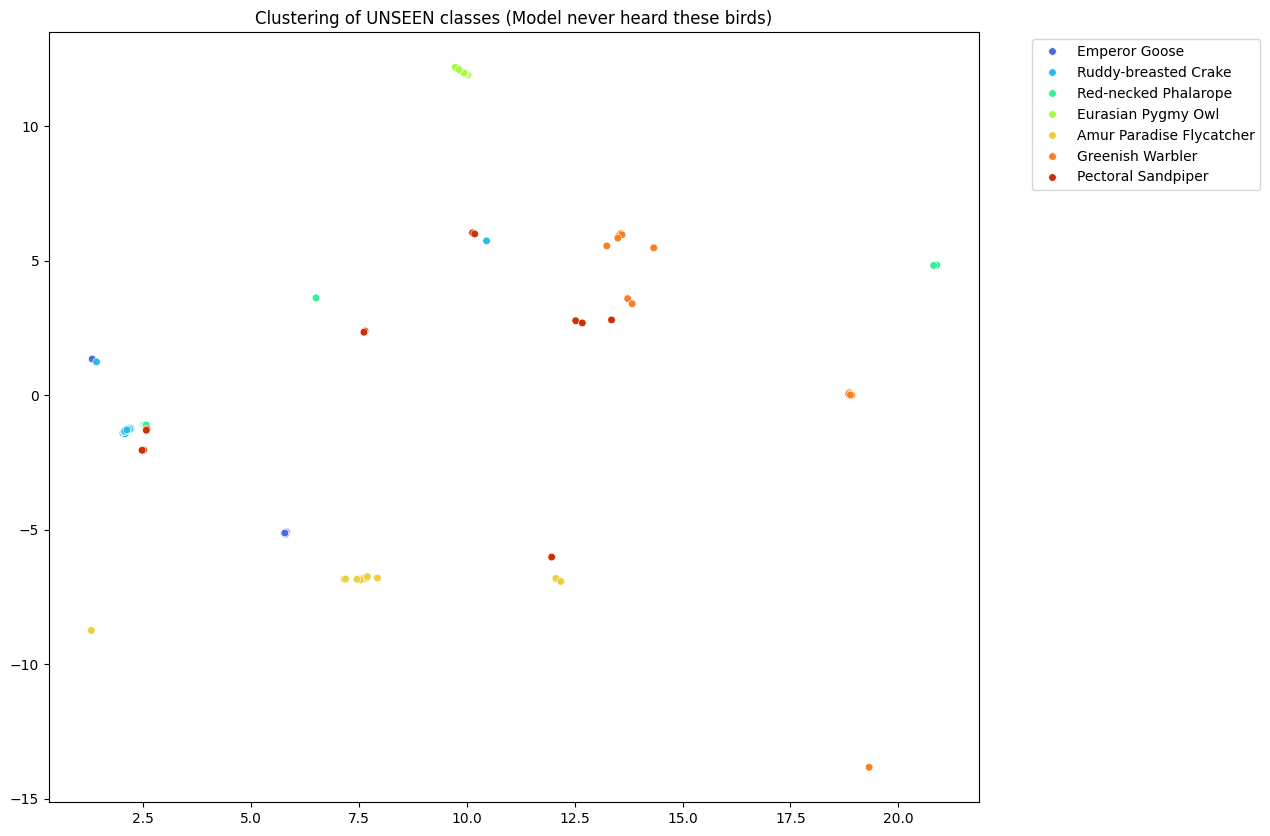

In [20]:
plt.figure(figsize=(12, 10))

# Выберем 15 рандомных unseen классов для наглядности
selected_classes = np.random.choice(list(unseen_classes), 15)
mask = np.isin(y_unseen, selected_classes)

sns.scatterplot(
    x=umap_unseen[mask, 0], 
    y=umap_unseen[mask, 1], 
    hue=y_unseen[mask], 
    palette='turbo', 
    s=30,
    legend='full'
)

plt.title("Clustering of UNSEEN classes (Model never heard these birds)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.show()

### Поиск ближайших соседей (Inference Demo)

In [37]:
from sklearn.neighbors import NearestNeighbors
import random 

# Строим индекс по Seen классам
knn = NearestNeighbors(n_neighbors=5, metric='cosine')
knn.fit(emb_val)

# Берем случайный unseen
idx = random.randint(0, len(emb_unseen)-1)
query_emb = emb_unseen[idx].reshape(1, -1)
query_label = y_unseen[idx]

distances, indices = knn.kneighbors(query_emb)

print(f"Query Bird: {query_label}")
print("-" * 30)
print("Closest birds from Training Set:")

for i, (dist, ind) in enumerate(zip(distances[0], indices[0])):
    neighbor_label = y_val[ind]
    print(f"{i+1}. {neighbor_label} (Dist: {dist:.4f})")

# Если дистанции большие (> 0.5-0.7), значит модель понимает, что это "неизвестный" класс.
# Если маленькие (< 0.2), значит она путает его с кем-то из знакомых.

Query Bird: Eurasian Pygmy Owl
------------------------------
Closest birds from Training Set:
1. Caspian Gull (Dist: 0.4392)
2. Caspian Gull (Dist: 0.4592)
3. Caspian Gull (Dist: 0.4675)
4. Caspian Gull (Dist: 0.4829)
5. Caspian Gull (Dist: 0.4857)
